In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import random
import subprocess
import sys
exc_dir = os.path.join(os.getcwd(), '..', '..')
sys.path.append(exc_dir)
sys.argv = sys.argv[:1]
import src.data_processor.data_utils as data_utils
from src.parse_args import parser
from src.utils import get_log_dir

def read_arguments(input_file):
    args = []
    with open(input_file) as f:
        for line in f:
            line = line.rstrip()
            if not line:
                continue
            if line.startswith('#'):
                continue
            assert('=' in line)
            arg_name, arg_val = line.split('=', 1)
            if arg_val.startswith('"') and arg_val.endswith('"'):
                if arg_val != '"False"':
                    args.append('--{}'.format(arg_name))
                    if arg_val != '"True"':
                        args.append(arg_val[1:-1])         
            else:
                args.append('--{}'.format(arg_name))
                args.append(arg_val)
    return parser.parse_args(args)

# Read variables in configuration file to sys.argv
config_file = os.path.join(exc_dir, 'configs/schema-ptr/scholar-schema-ptr.sh')
args = read_arguments(config_file)

vis_dir = os.path.join(exc_dir, get_log_dir('visualizations', args, with_time_stamp=False).replace("'", ''))
latest_sub_dir = None
for sub_dir in os.listdir(vis_dir):
    if latest_sub_dir is None:
        latest_sub_dir = sub_dir
    elif sub_dir > latest_sub_dir:
        latest_sub_dir = sub_dir
vis_dir = os.path.join(vis_dir, latest_sub_dir)

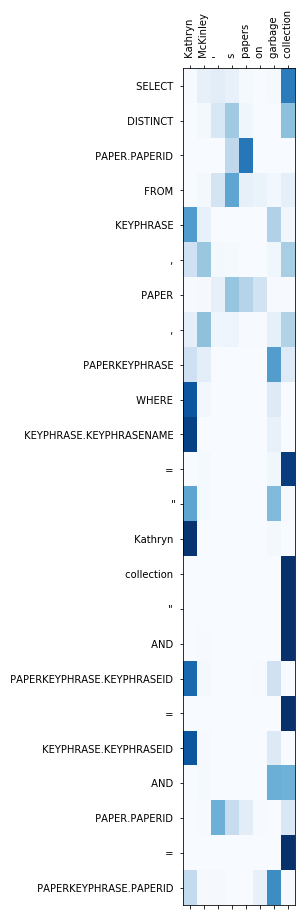

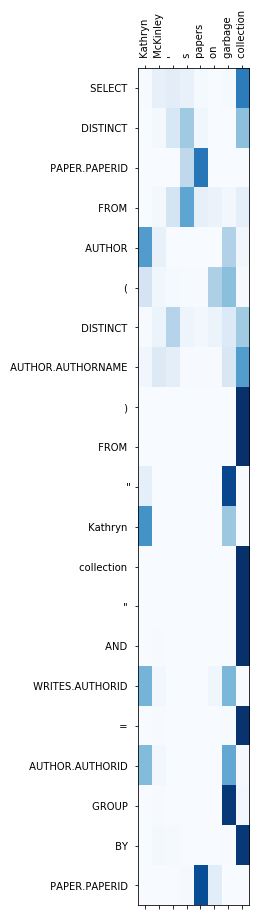

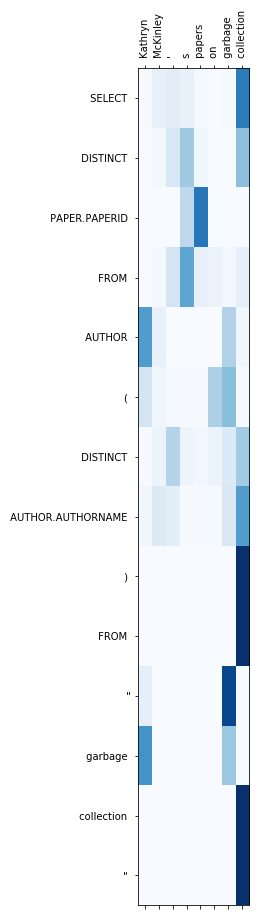

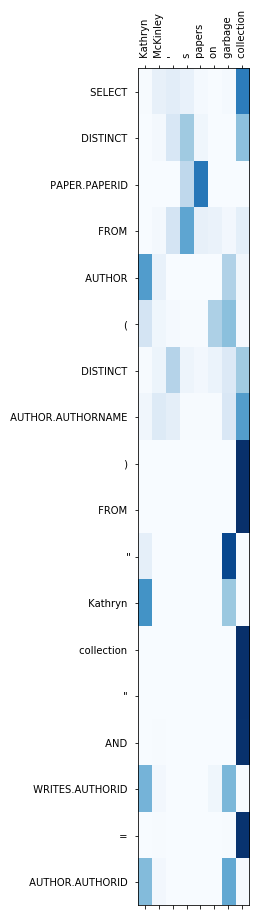

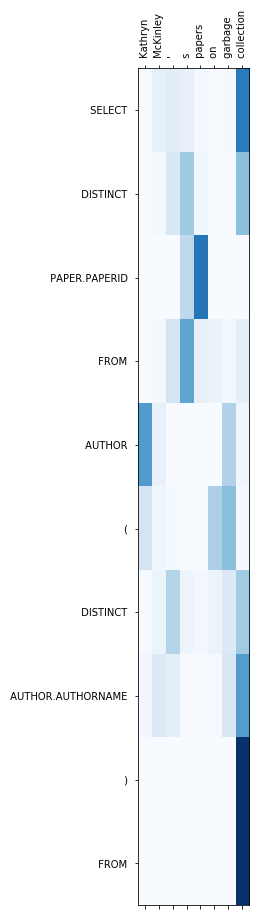

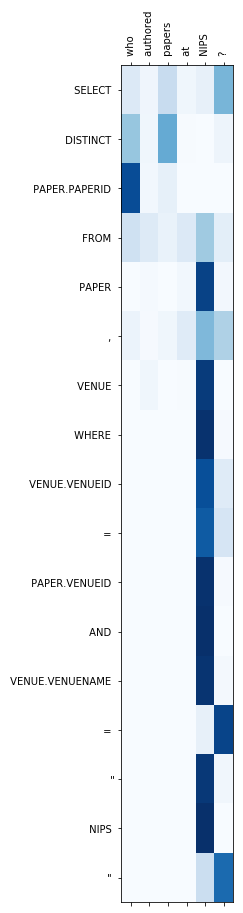

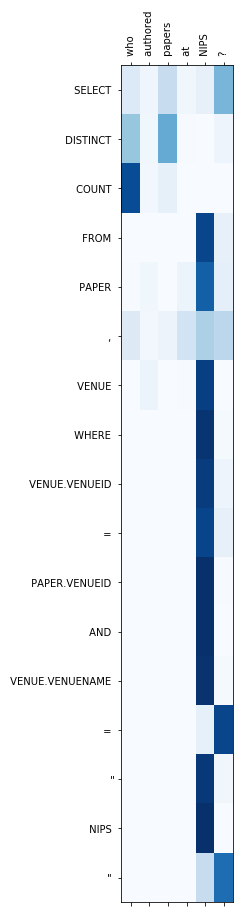

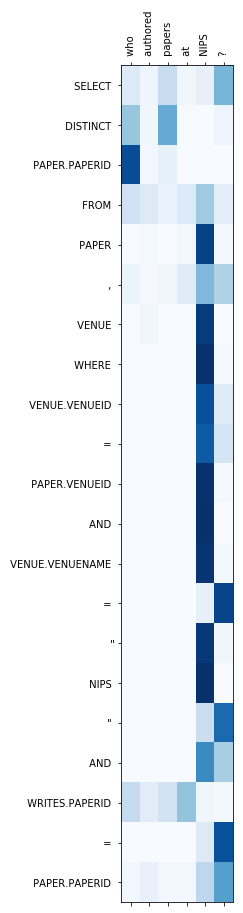

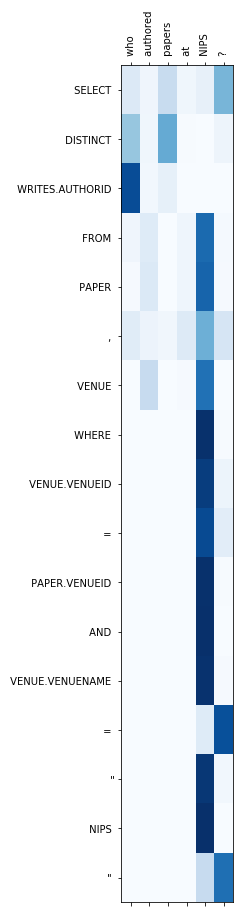

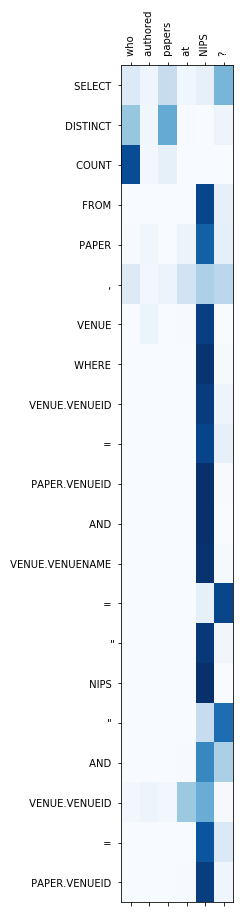

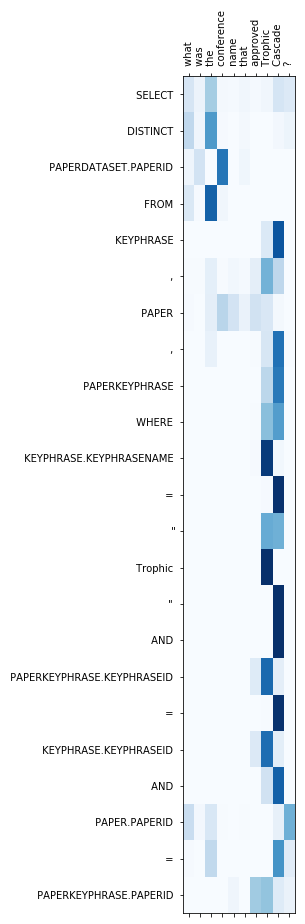

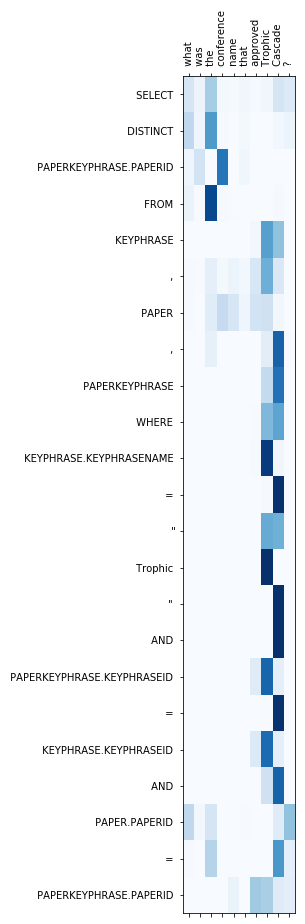

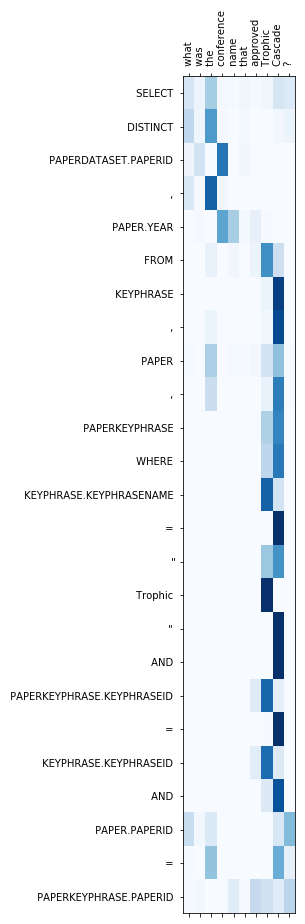

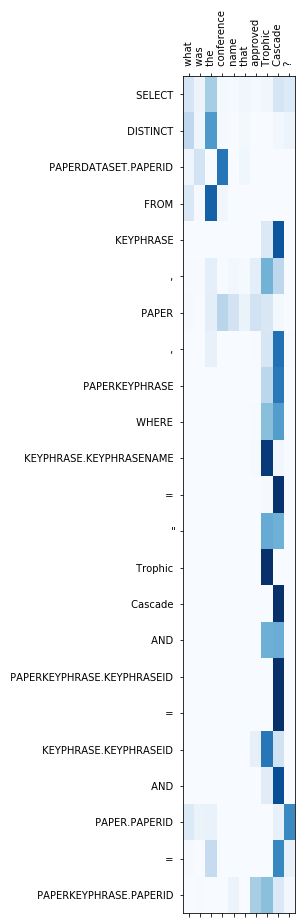

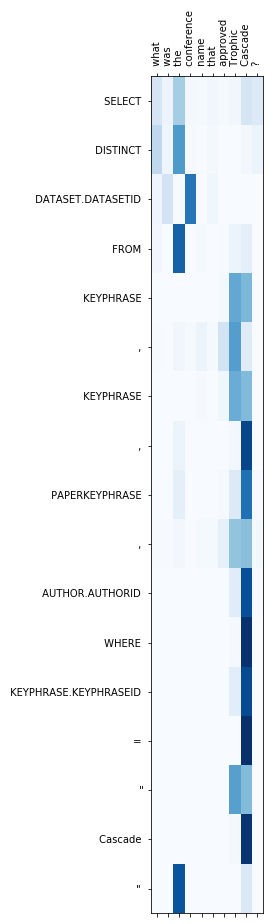

In [15]:
# Visualize cross sequence attention
randomized = False
# example_ids = [0, 2, 8, 12, 32, 43, 63, 64, 73, 74, 78, 80]
example_ids = [42, 86, 89]
def pad_sequence(seq, target_len):
    len_res = target_len - len(seq)
    return seq + [data_utils.PAD_TOKEN]*len_res

def vis_cross_attn(in_tokens, out_tokens, attn_weights, attn_target_label, cmap='Blues'):
    num_heads, out_seq_len, in_seq_len = attn_weights.shape
    assert(num_heads == args.cross_attn_num_heads)
    multi_head_attn_weights = []
    for i in range(num_heads):
        multi_head_attn_weights.append(attn_weights[i][:, :len(in_tokens)][:len(out_tokens), :])
    multi_head_attn_weights = np.concatenate(multi_head_attn_weights, axis=1)
    if attn_target_label == 'text':
        fig = plt.figure(figsize=(int(in_seq_len / (8/num_heads)), int(out_seq_len / 8)))
    elif attn_target_label == 'schema':
        fig = plt.figure(figsize=(int(in_seq_len / (4/num_heads)), int(out_seq_len / 8)))
    else:
        raise NotImplementedError
    plt.matshow(multi_head_attn_weights, cmap=cmap, aspect='auto', fignum=fig.number)
    plt.xticks(np.arange(len(in_tokens) * num_heads), in_tokens * num_heads, rotation=90)
    plt.yticks(np.arange(len(out_tokens)), pad_sequence(out_tokens, out_seq_len))
    
in_pkl = os.path.join(vis_dir, 'text_attention.pkl')
with open(in_pkl, 'rb') as f:
    vis_data = pickle.load(f)
    if randomized:
        random.shuffle(vis_data)
    for i, example_id in enumerate(example_ids):
        for j in range(args.beam_size):
            example = vis_data[example_id * args.beam_size + j]
            vis_cross_attn(example[0], example[1], example[2], 'text')

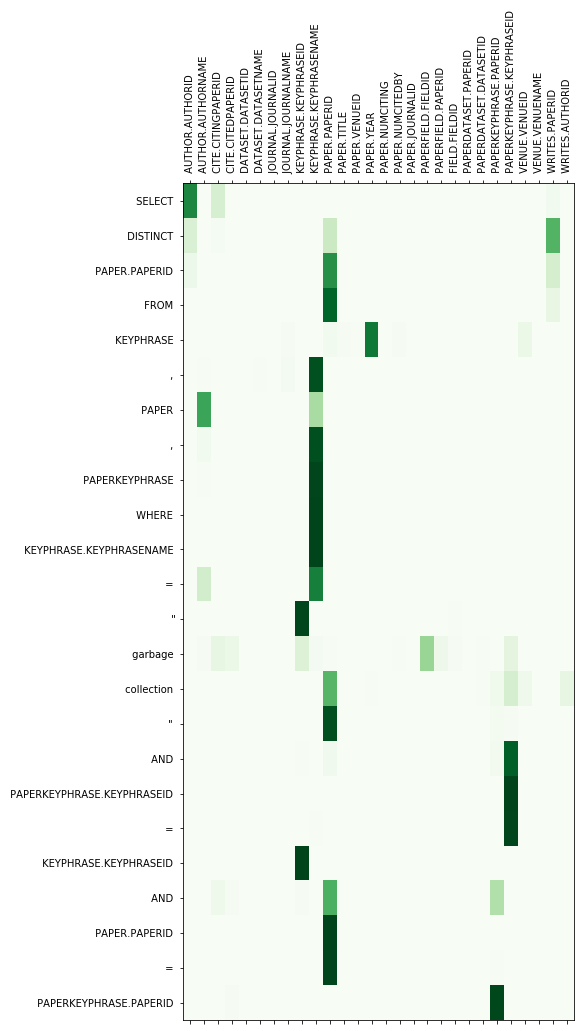

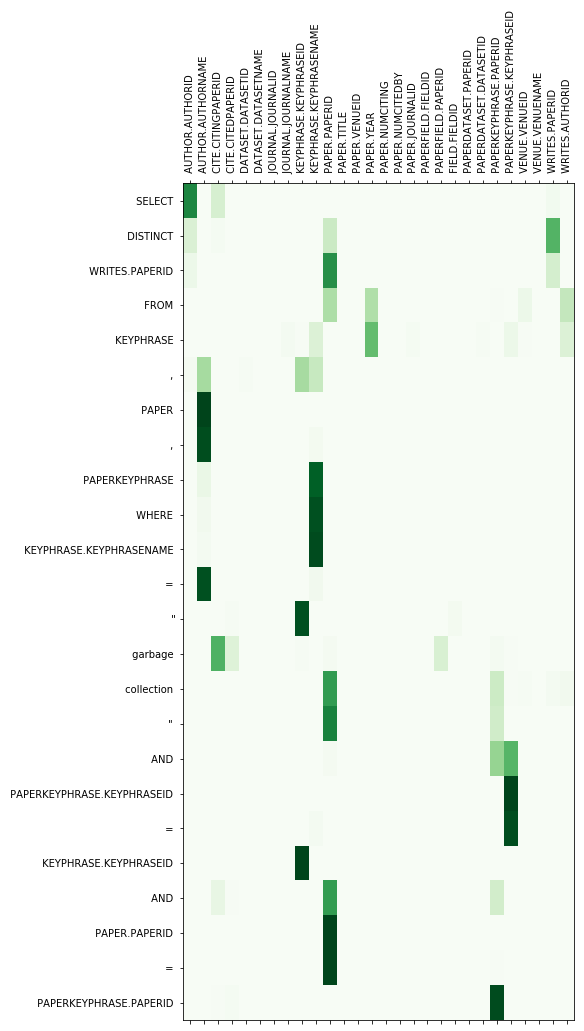

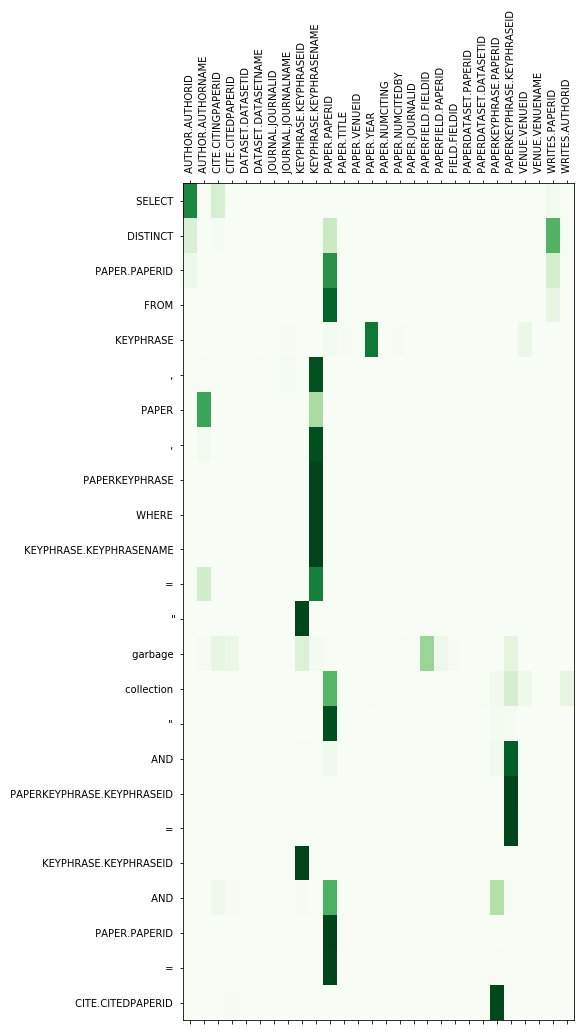

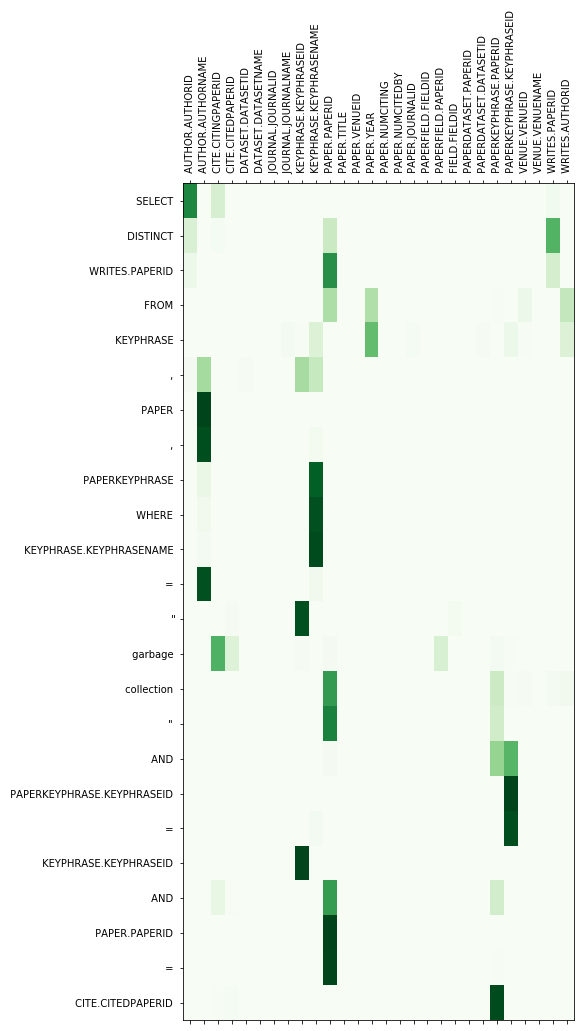

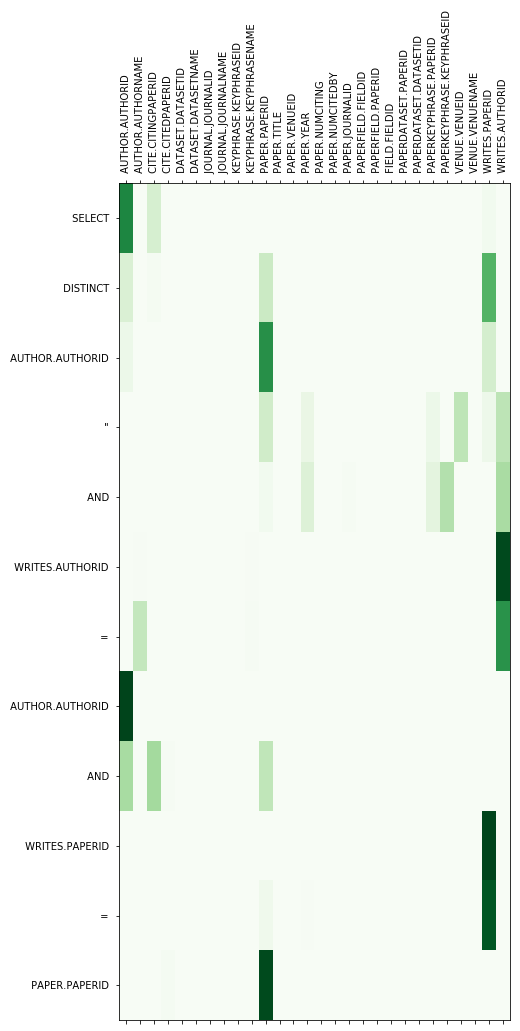

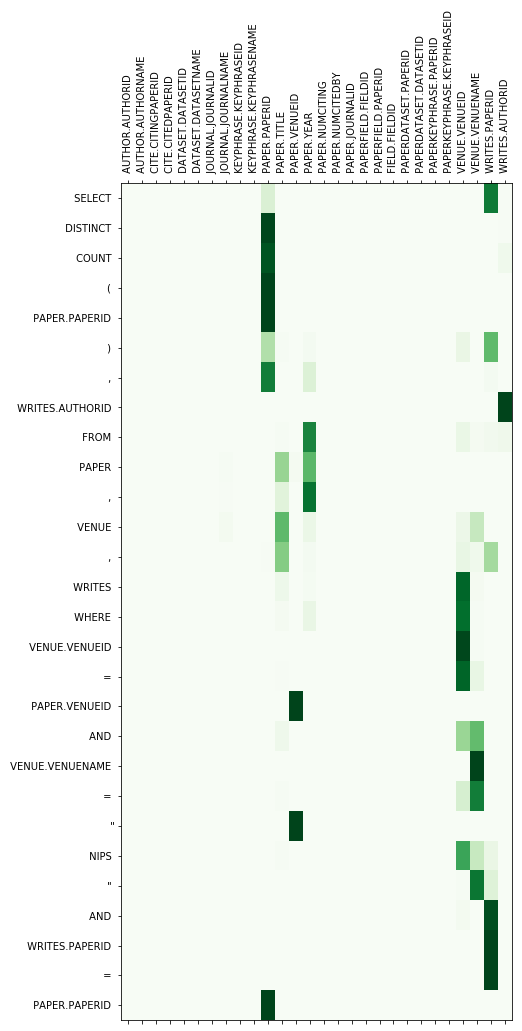

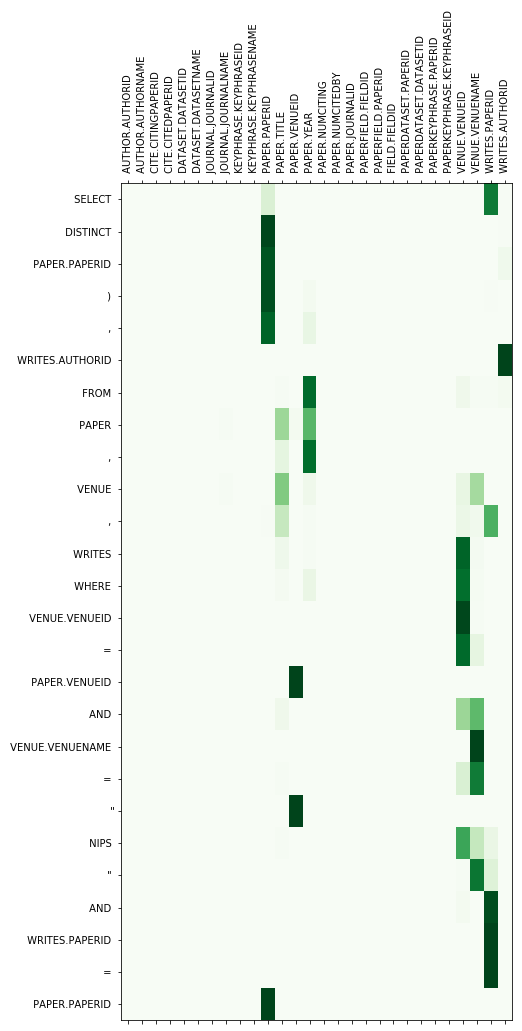

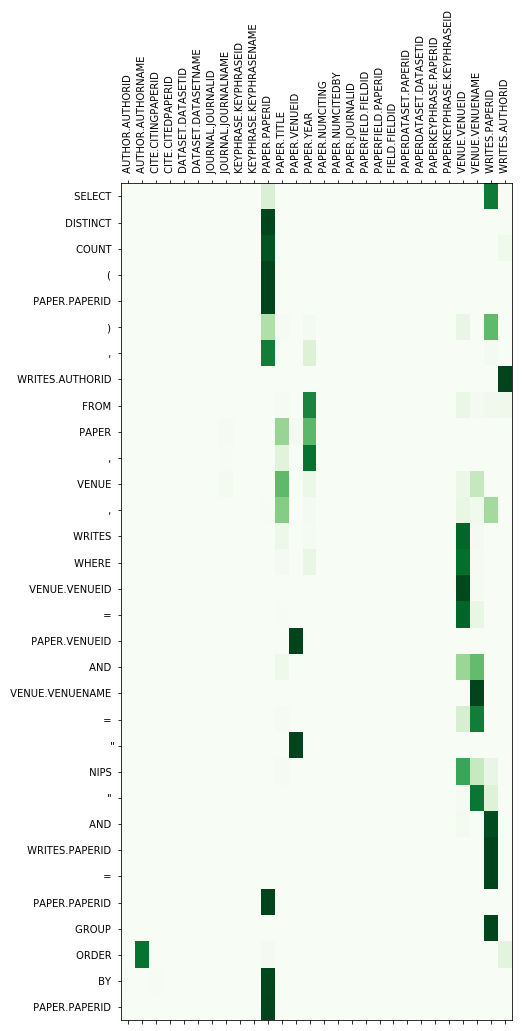

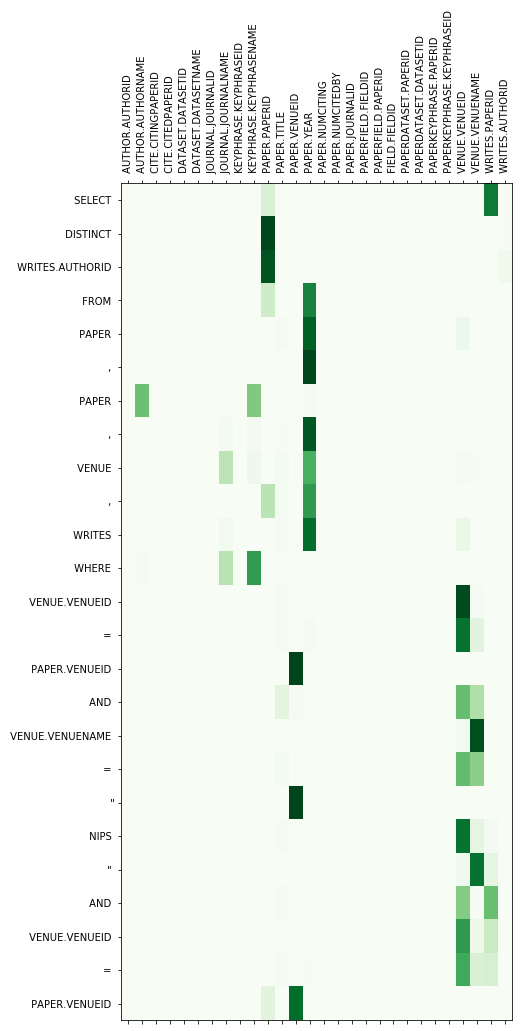

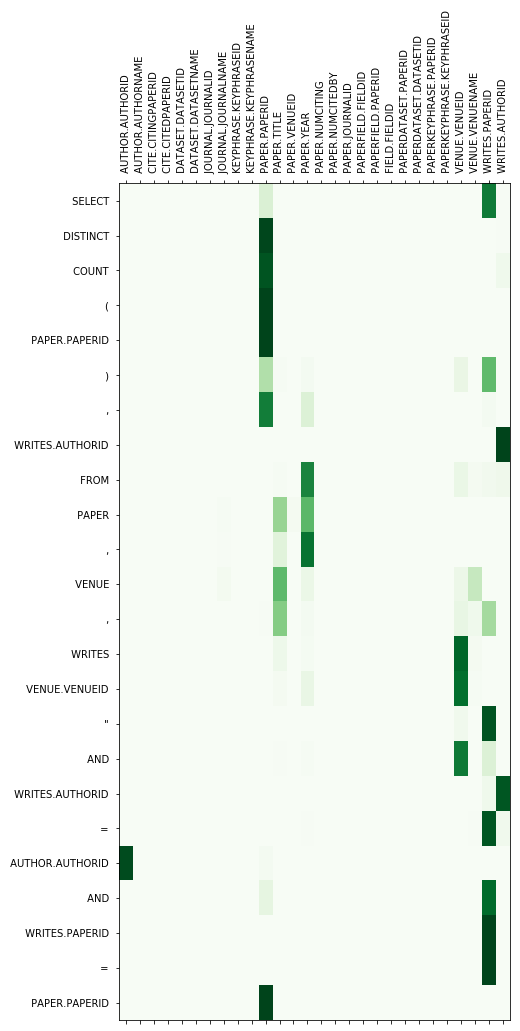

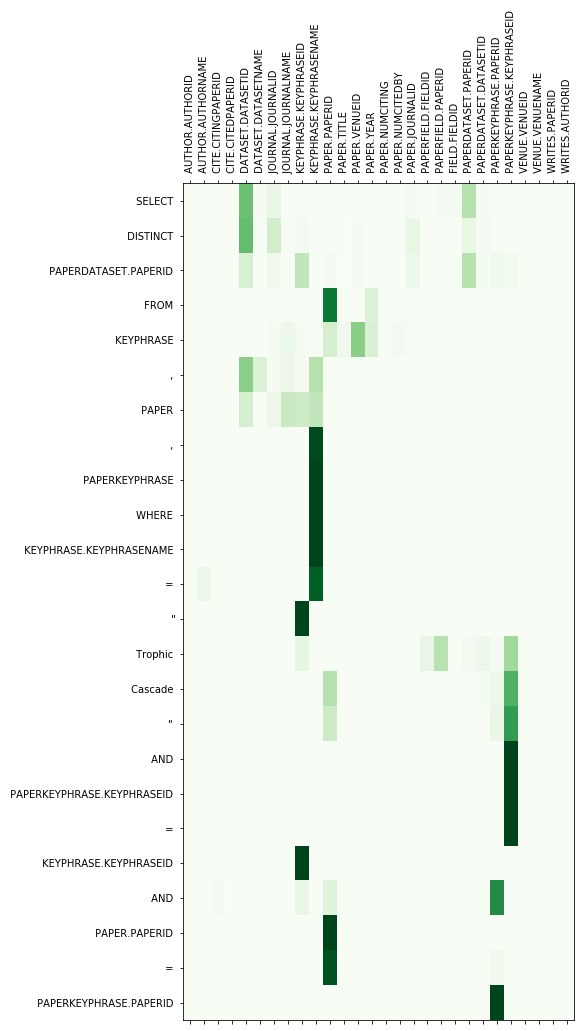

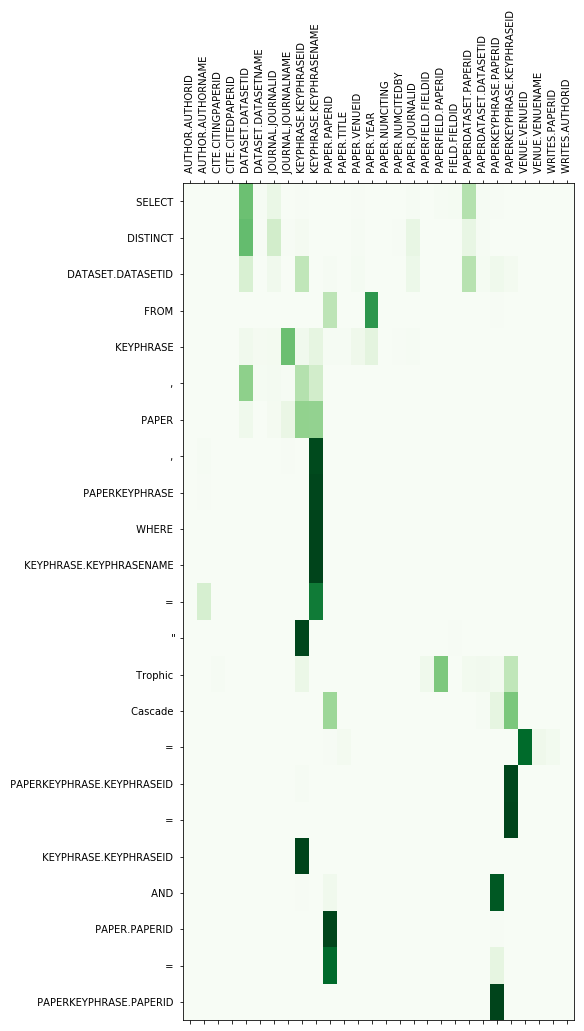

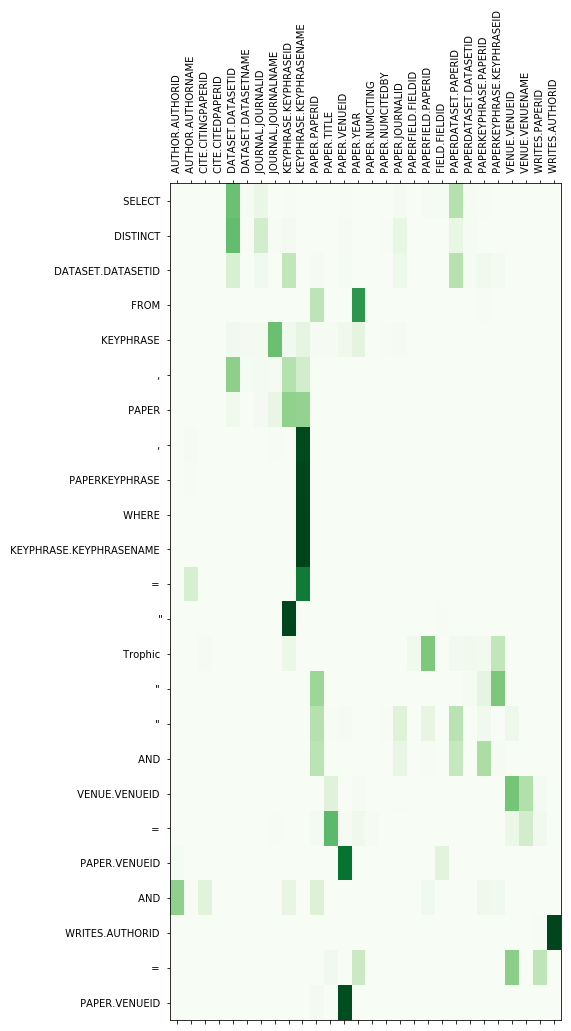

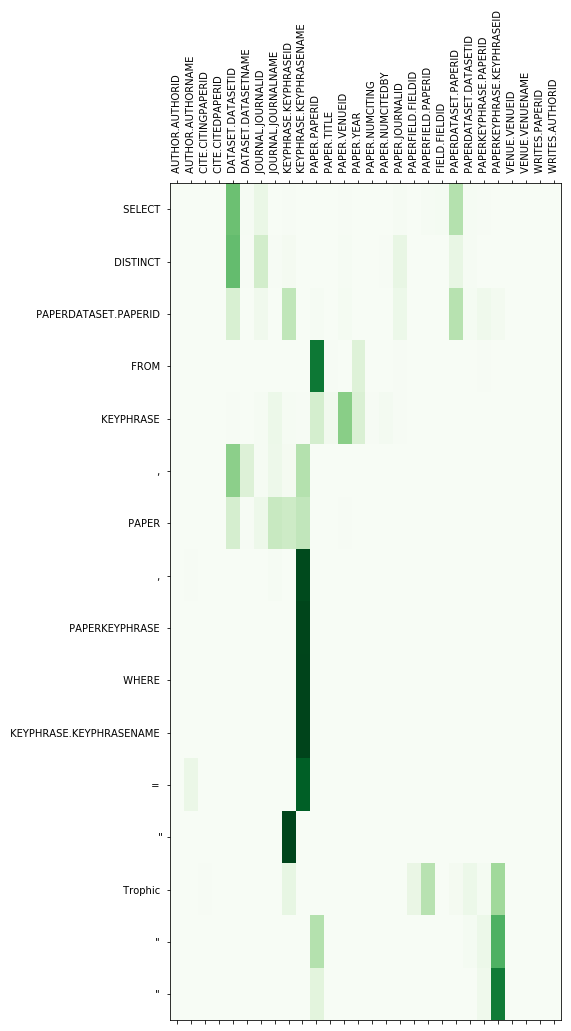

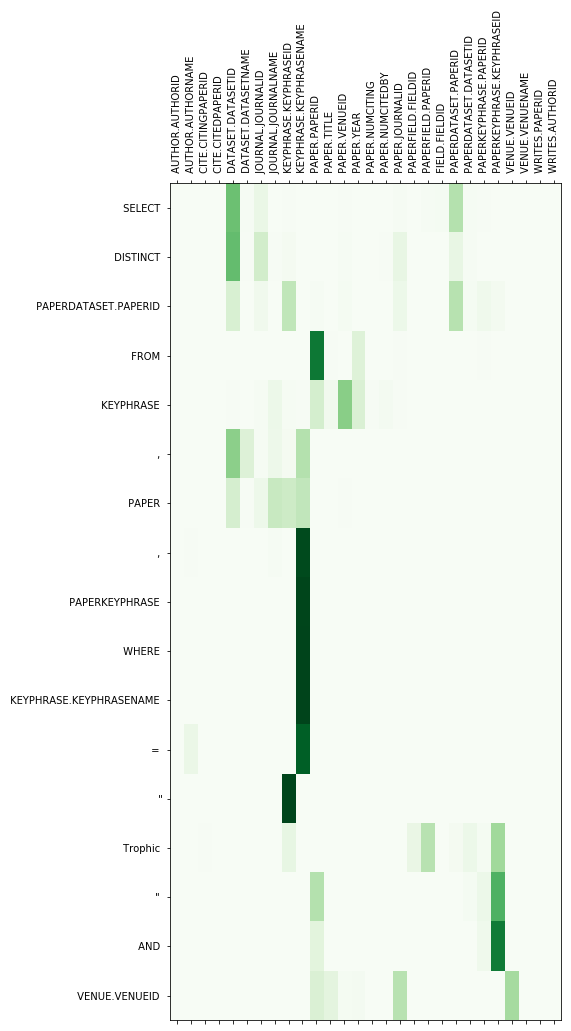

In [13]:
in_pkl = os.path.join(vis_dir, 'schema_attention.pkl')
with open(in_pkl, 'rb') as f:
    vis_data = pickle.load(f)
    if randomized:
        random.shuffle(vis_data)
    for i, example_id in enumerate(example_ids):
        for j in range(args.beam_size):
            example = vis_data[example_id * args.beam_size + j]
            vis_cross_attn(example[0], example[1], example[2], 'schema', cmap='Greens')

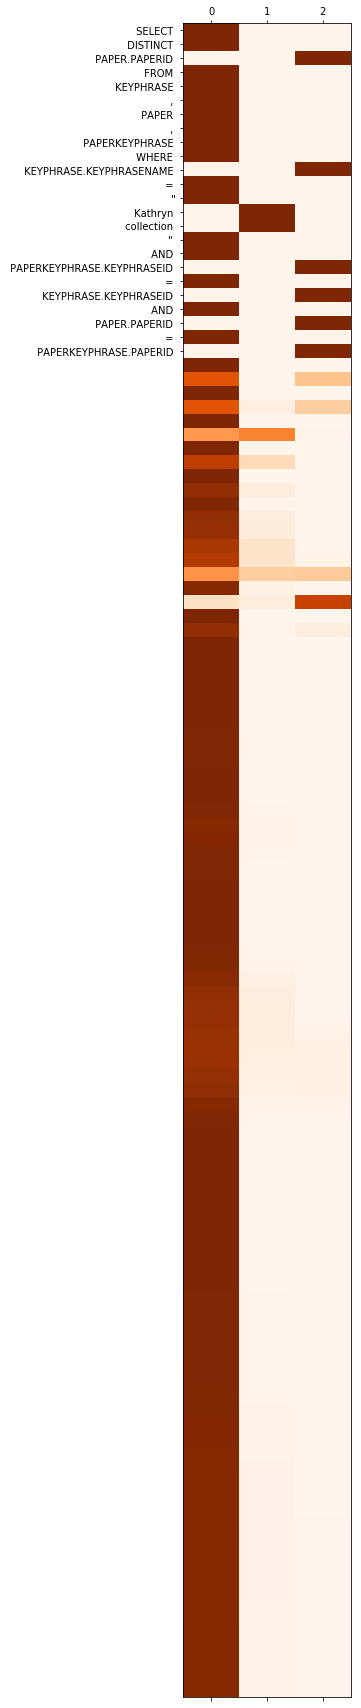

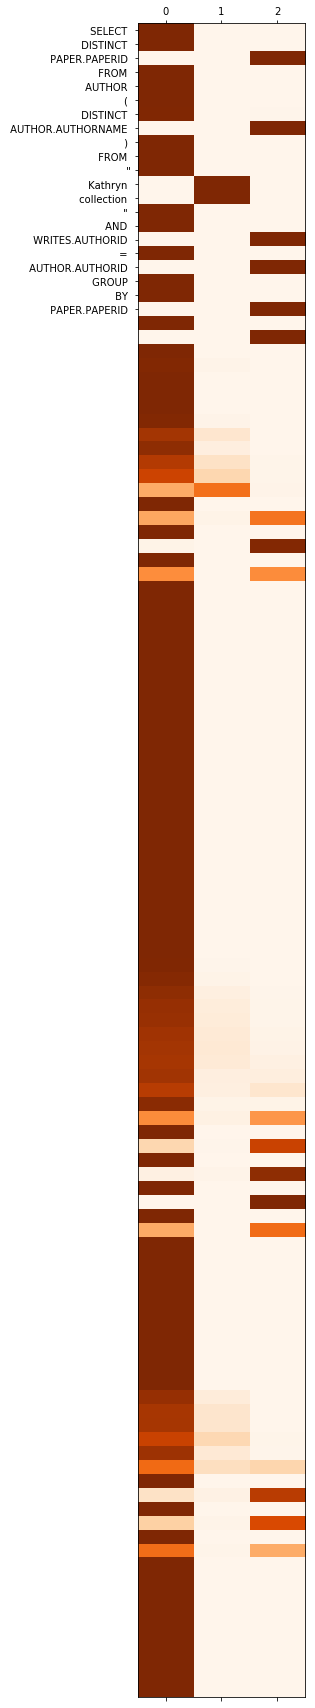

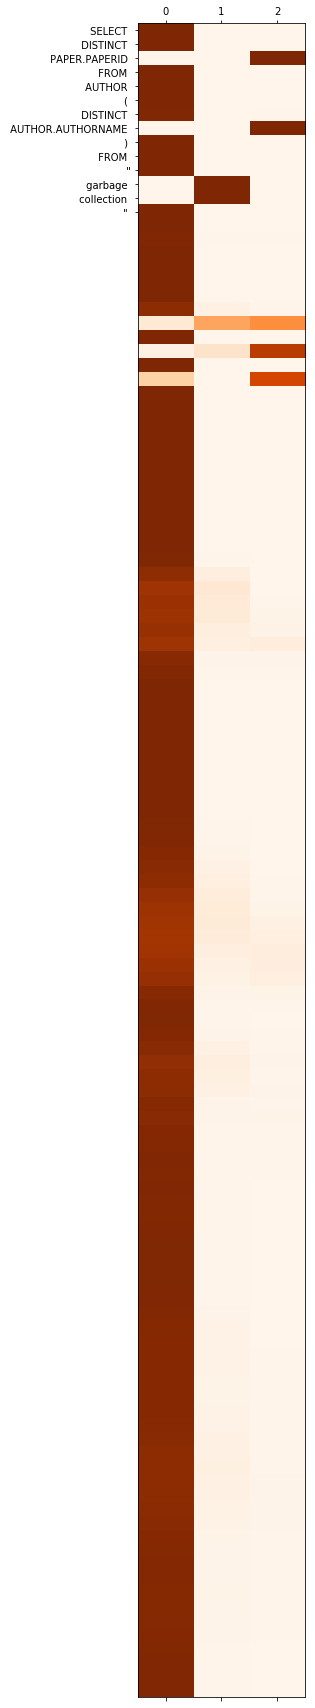

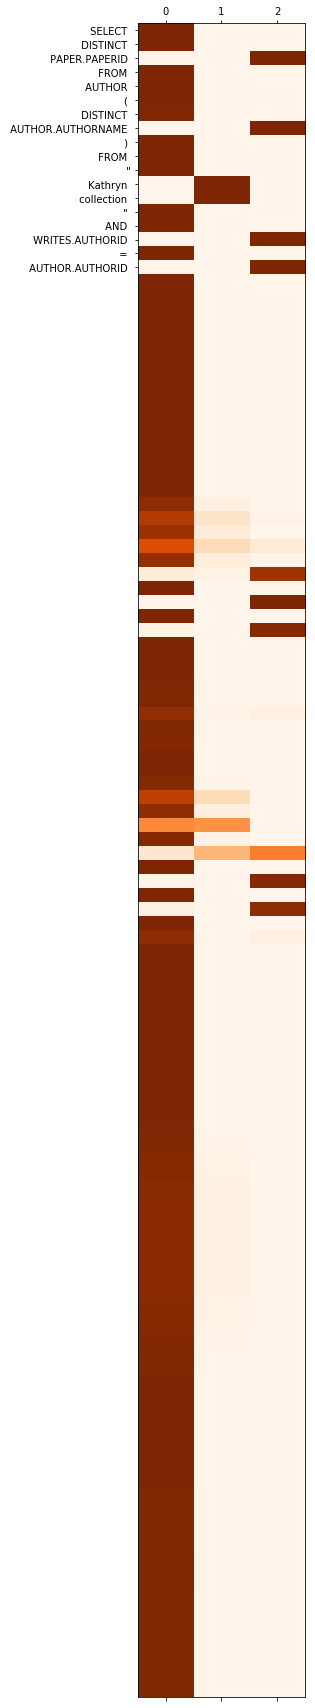

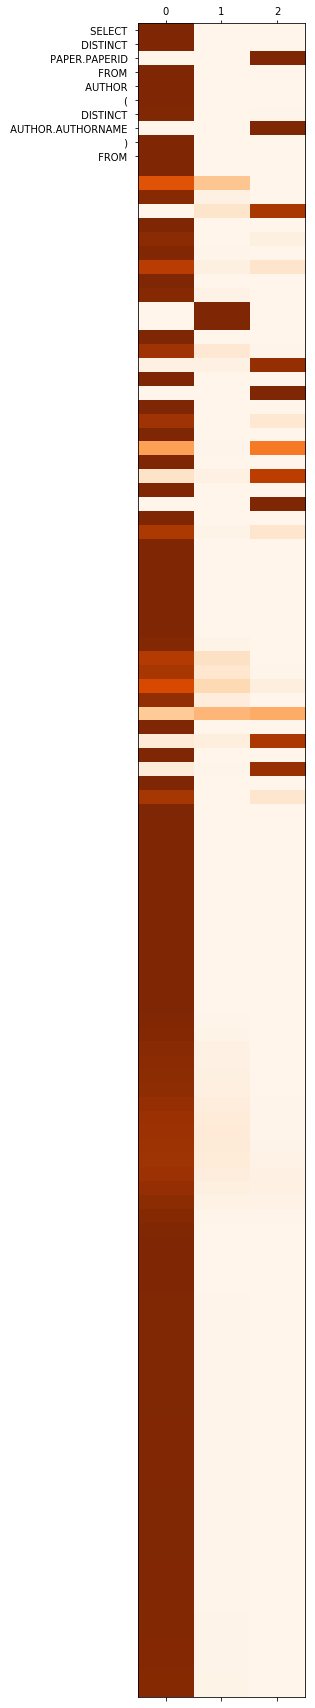

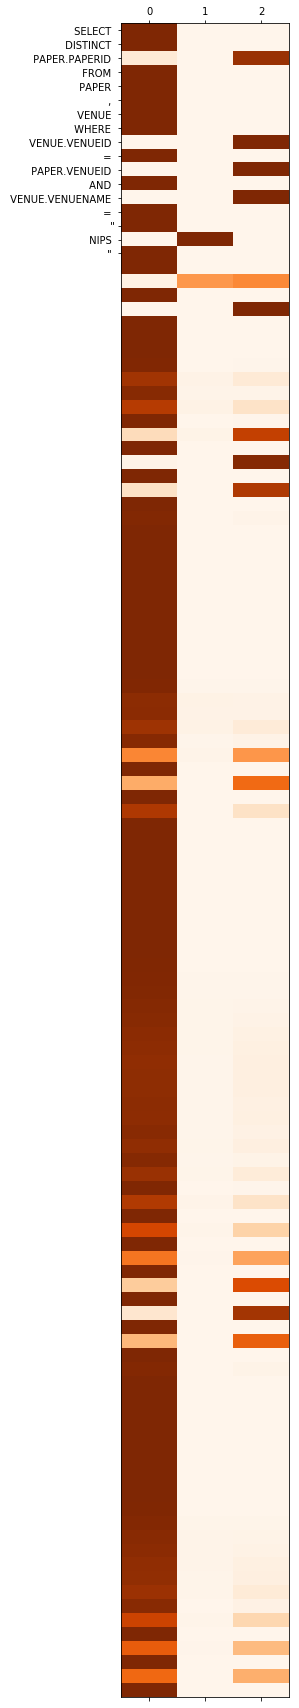

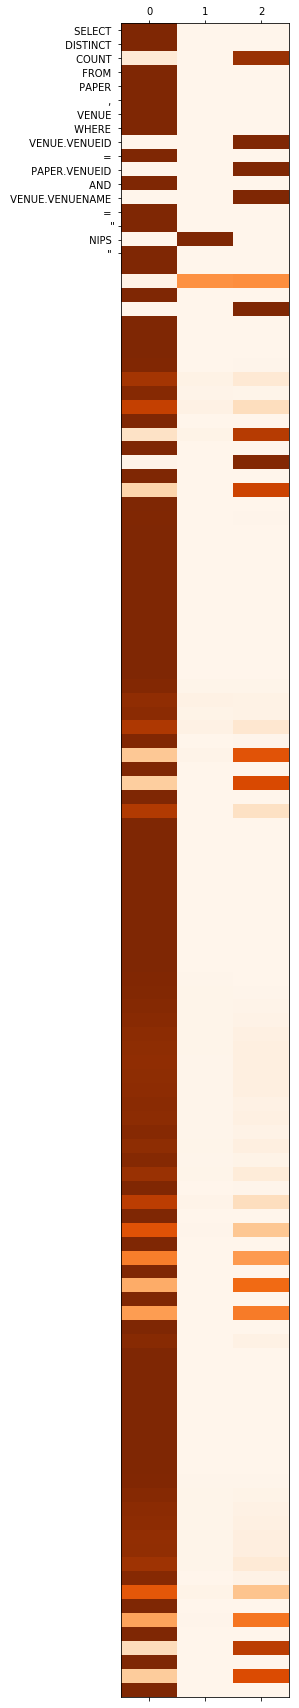

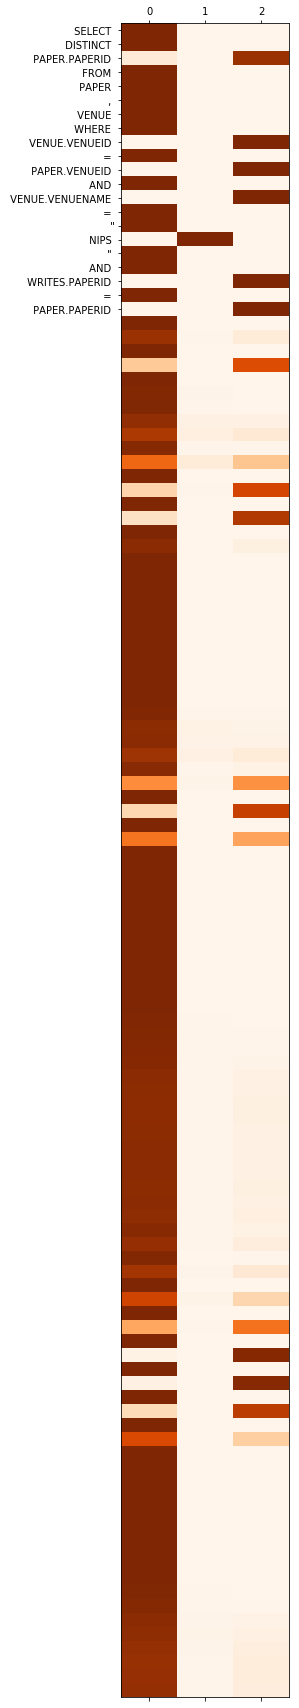

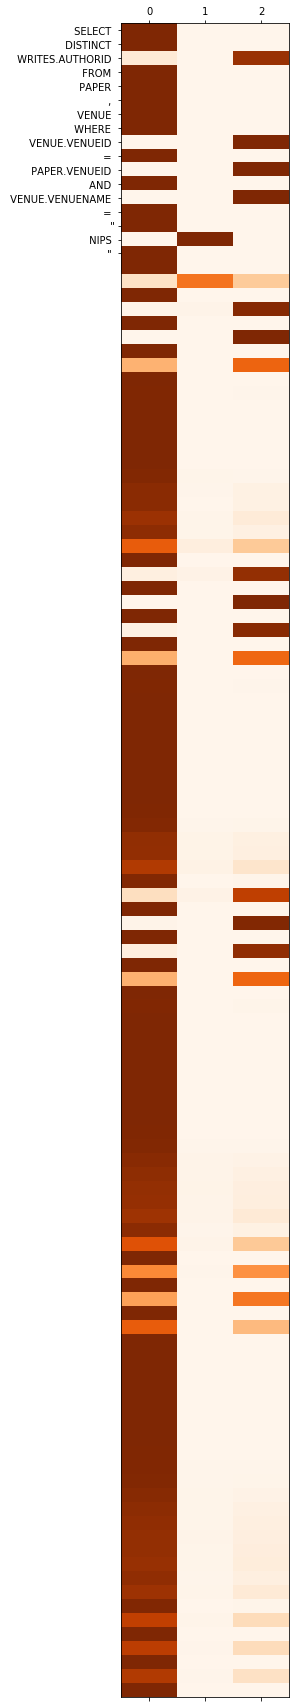

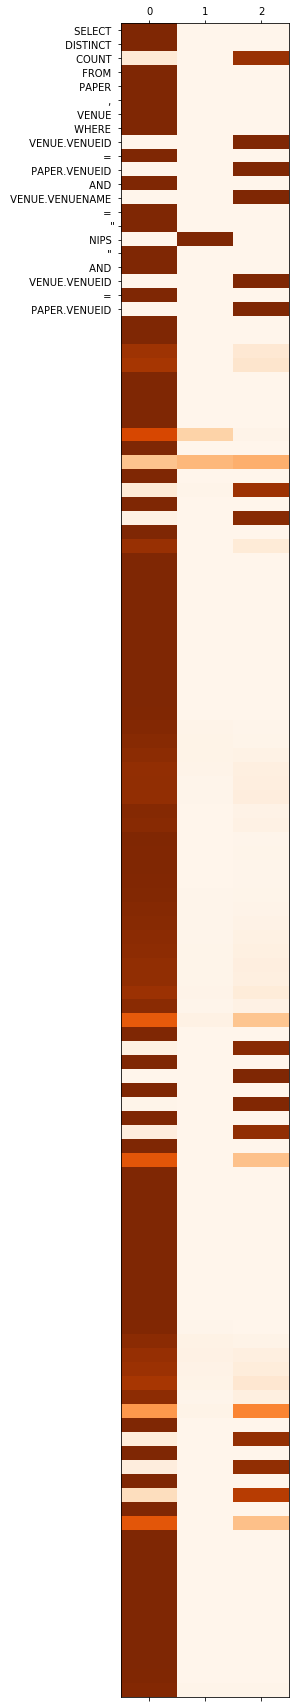

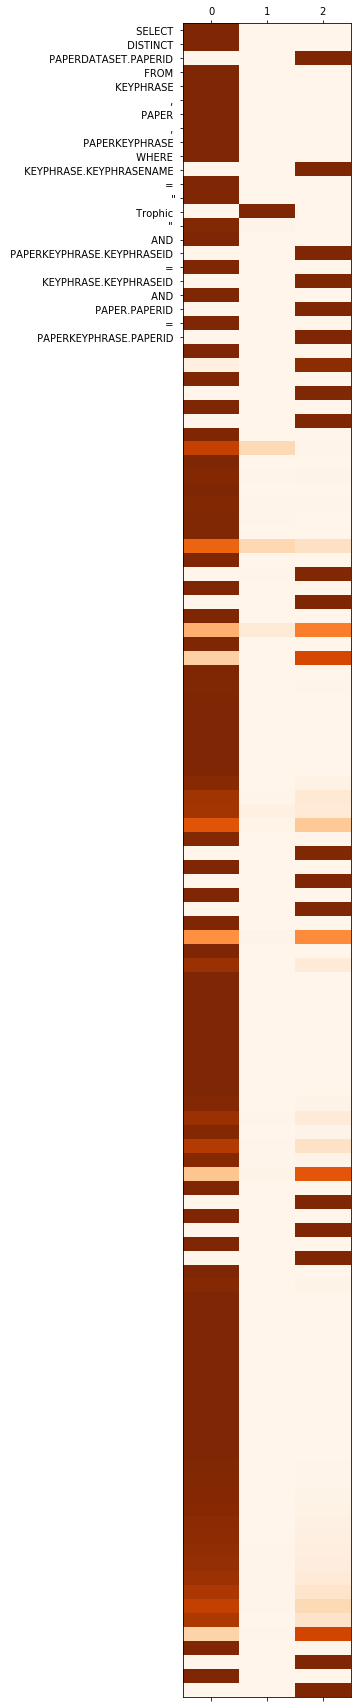

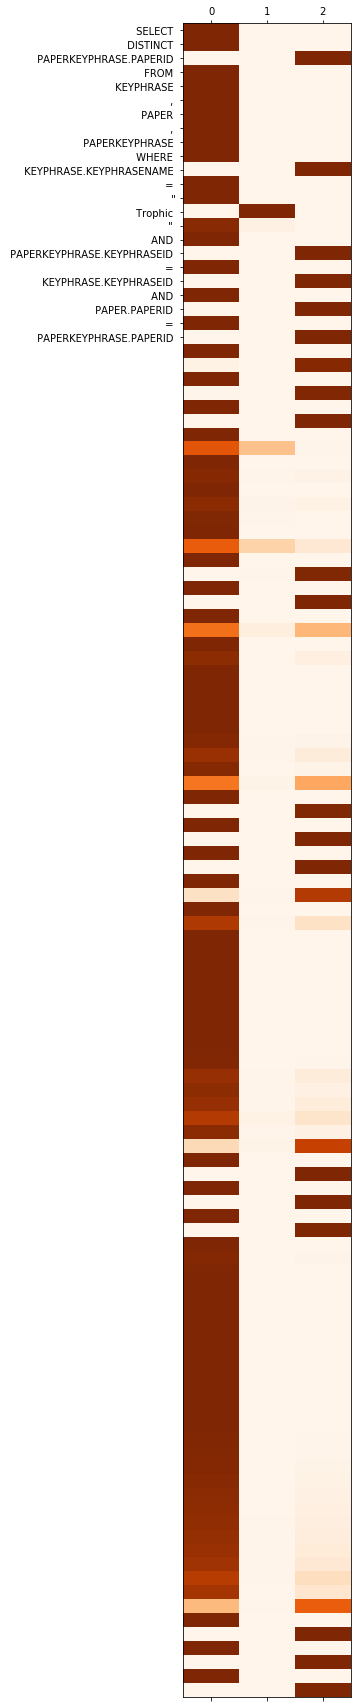

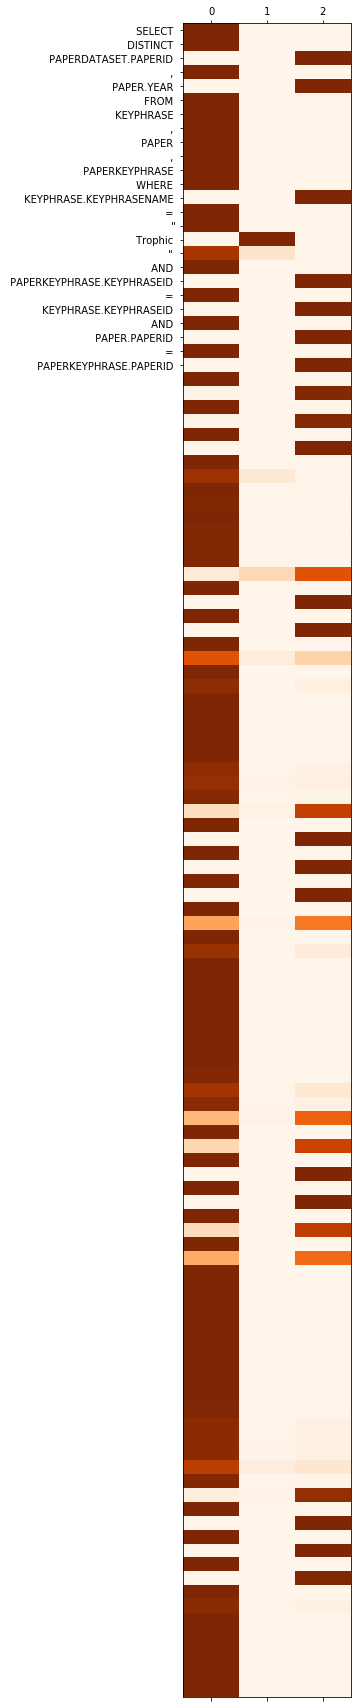

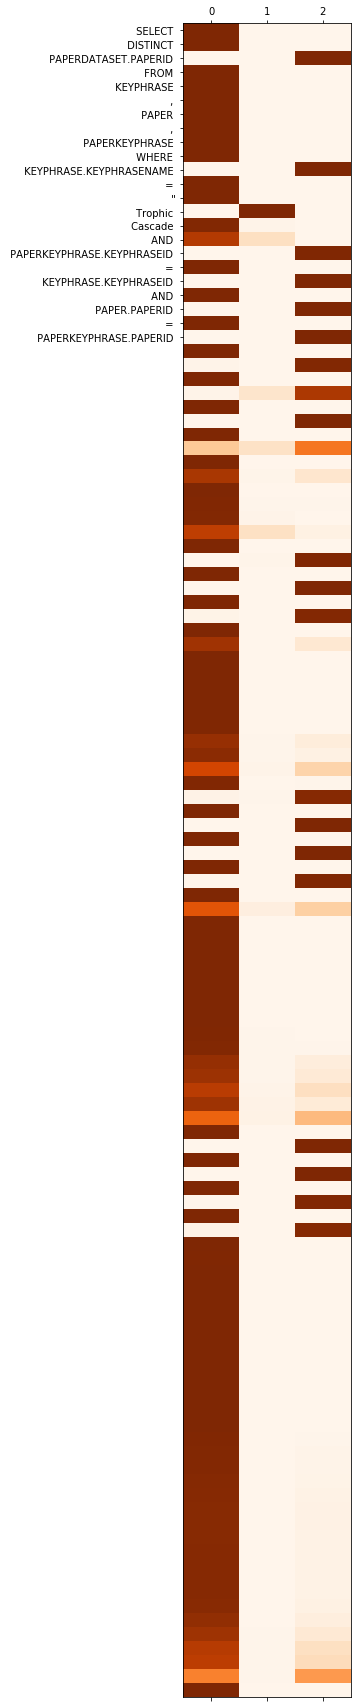

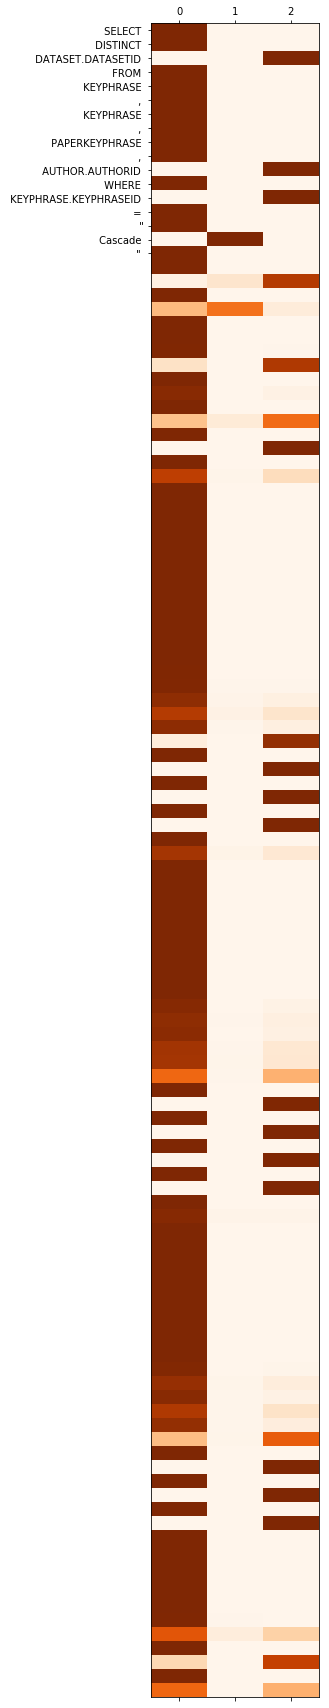

In [16]:
def vis_pointer(out_tokens, pointer_weights):
    out_seq_len, num_pointer_heads = pointer_weights.shape
    fig = plt.figure(figsize=(3, int(out_seq_len/4)))
    plt.matshow(pointer_weights, cmap='Oranges', aspect='auto', fignum=fig.number)
    plt.yticks(np.arange(len(out_tokens)), pad_sequence(out_tokens, out_seq_len))

in_pkl = os.path.join(vis_dir, 'all_pointer.pkl')
with open(in_pkl, 'rb') as f:
    vis_data = pickle.load(f)
    if randomized:
        random.shuffle(vis_data)
    for i, example_id in enumerate(example_ids):
        for j in range(args.beam_size):
            example = vis_data[example_id * args.beam_size + j]
            vis_pointer(example[0], example[1])